In [1]:
import sys
import os
import random
import math
from tqdm import tqdm
import time


import numpy as np 
from numpy import cos, sin
import numpy.linalg as LA
from numpy import cos, sin, sqrt, cross

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

import matplotlib
import matplotlib.pyplot as plt


import plotly.figure_factory as ff
import plotly.graph_objects as go

import pickle as pkl
import PIL.Image as Image



from PIL import Image
import copy
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp




import gym
from gym import Env, spaces
import time
import operator



from datetime import datetime
import navpy as nav


from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range
from poliastro.constants import J2000
from poliastro.plotting import OrbitPlotter3D
from poliastro.plotting import OrbitPlotter2D
from poliastro.twobody.sampling import EpochsArray, TrueAnomalyBounds, EpochBounds
from poliastro.maneuver import Maneuver
from poliastro.twobody.propagation import propagate, cowell
from poliastro import constants



from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.utils.data import conf
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

from astroquery.jplhorizons import Horizons

conf.dataurl
conf.remote_timeout = 10000
solar_system_ephemeris.set("jpl")


<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
%config IPCompleter.greedy=False
%load_ext autoreload
%autoreload 2

# Initialization

## Assumptions and Justification

 - no drag forces accounted for. The altitude is high enough that the acceleration due to drag
even for cases with large cross sections is orders of magnitude smaller than other perturbations

 - The orbit remains roughly circular throughout chaser burns, and the period changes at roughly the same rate
 throughout as well
 
 - the initial difference in phase (true anomaly) between chaser and target is arbitrary, and to be accounted for
 
 - the ultimate simulation metric by which to judge the validity of the guidance law is the minimum difference in position
 between the chaser and target craft
 - an additional factor of safety for the 7 day time limit is added. This results in 7 - target sat orbital period in order to allow time for coincidence of the two spacecraft once in coinciding orbits
 

# Classes

## Dynamical Environments

In [373]:
class TwoBodycoe:
    
    def __init__(self, mu, sat_acc, B, R, J2, mode='Perturbed'):
        
#         self.primary_mass = primary_mass  # Mass of the primary body in the 2BP
#         self.primary_radius = primary_radius
        
        self.satellites = []              # Initialized with no objects
        
        self.mu = mu
        
        self.acc = sat_acc
        
        self.B = B
        
        self.J2 = J2
        
        self.R = R
        
        self.mode = mode
        
    def Equations_of_Motion(self, t, y):
        a, i, nu, raan = y
        if self.mode == 'Perturbed':


            fac1 = self.J2*self.mu*((self.R**2)/a**4)*3

            h = sqrt(mu*a)

            dnu = h/(a**2)

            da = 2*((a**2)/h)*(self.acc*cos(self.B) - fac1*(sin(i)**2)*sin(nu)*cos(nu))

            di = (a/h)*cos(nu)*(self.acc*sin(self.B) - fac1*sin(i)*cos(i)*sin(nu))



            draan = self.acc*(a/h)*(sin(nu)/sin(i))*sin(self.B)
            
        else:
            


            h = sqrt(mu*a)

            dnu = h/(a**2)

            da = 2*((a**2)/h)*(self.acc*cos(self.B))

            di = (a/h)*cos(nu)*(self.acc*sin(self.B))



            draan = self.acc*(a/h)*(sin(nu)/sin(i))*sin(self.B) 

            



        dxdt = np.array([da, di, dnu, draan])
        return dxdt

    def add_satellite(self, satellite):
        # Add a component to the satellite
        self.satellites.append(satellite)

    def propagate_satellites(self, dt):



        
        for satellite in self.satellites:
            
            t_span = (satellite.time, satellite.time + dt)
            
            x_0 = np.array([satellite.a, satellite.inc, satellite.nu, satellite.raan])

            sol = solve_ivp(self.Equations_of_Motion, t_span, x_0, dense_output='True', method = 'LSODA', rtol=1e-12, atol=1e-14 )

#             print(sol.y[:,-1])
#             print(sol.t[-1])
#             print(sol.y.shape)
            satellite.a = sol.y[0,-1]
            satellite.inc = sol.y[1,-1]
        
            nu =sol.y[2,-1]
            nu = wrap_true_anomaly(nu)
            satellite.nu = nu
            
            satellite.raan = sol.y[3,-1]
            satellite.time = sol.t[-1]
            
          
            
            satellite.a_s.append(sol.y[0,-1])
            satellite.incs.append(sol.y[1,-1])
            satellite.nus.append(nu)
            satellite.raans.append(sol.y[3,-1])
            satellite.times.append(sol.t[-1])
            
            position_vector, _ = classical_elements_to_cartesian(satellite.a, 0, satellite.inc, satellite.raan, 0, satellite.nu, satellite.mu)            
            
            satellite.positions.append(position_vector)
            
            
#             if satellite.nu > np.pi:
#                 satellite.nu = np.mod(satellite.nu, np.pi)
#                 self.B *= -1
#             print(satellite.a)
#             print(satellite.inc)
#             print(satellite.nu)            


## Spacecraft Objects

In [60]:
class Satellite:
    def __init__(self, name, mass, a, ecc, inc, RAAN, nu, argp = 0):
        
        self.name = name          # Satellite name
        self.mass = mass          # kg
        self.a = a
        self.ecc = ecc
        self.inc = inc
        self.nu = nu
        
        self.a_s = []
        self.incs = []
        self.nus = []
        self.times = []
        self.raans = []
        self.positions = []
        self.thrust_profile = []
        
        
        self.raan = RAAN
        self.argp = argp
        self.p = a*(1-ecc**2)/(1+ecc*cos(nu))
        self.mu = 398600.4418
        self.T = (2*np.pi/(np.sqrt(self.mu)))*a**1.5
        print(self.T)
        position_vector, velocity_vector = classical_elements_to_cartesian(self.p, self.ecc, self.inc, self.raan, self.argp, self.nu, self.mu)
        
        #CONVERT TO POSITION AND VEL
        self.position = position_vector  # km
        self.velocity = velocity_vector  # km/s
        self.acceleration = [0.0, 0.0, 0.0]    # km/s^2
        self.STM = np.eye(6)             # initial identity matrix for the state transition matrix
        self.ephemerides = []            # empty list to store ephemerides in
        self.time = 0                    # initial relative time

        
    def display_info(self):
        # Display information about the satellite
        print(f"Satellite Name: {self.name}")
        print(f"Mass: {self.mass} kg")
        print(f"GEO position: {self.position} km")
        print(f"GEO Velocity: {self.velocity} km/s")
        
        print(f"semi-major axis: {self.a} km")
        print(f"eccentricity: {self.ecc} ")
        print(f"inclination: {self.inc} rad")
        print(f"RAAN: {self.raan} rad")
        

        
        

# Functions

In [ ]:
def wrap_true_anomaly(angle):
    wrapped_angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

In [23]:
def calculate_dV_cost(psi, acc,tof):
    dV = 2*abs(acc)*psi*tof/np.pi
    return dV

In [24]:
def calculate_coast_time(dnu, nu2, nu1, T2, T1):
    
    dnu1dt = 2*np.pi/T1
    dnu2dt = 2*np.pi/T2
    
#     dnu = np.where(dnu < 0, dnu + np.pi, dnu)
    diff = -(dnu2dt - dnu1dt)
    
    toc = dnu/diff
    
    return toc

In [385]:
def calculate_phase_change(dnu, nu2, nu1, T2, T1, t):
    
    dnu1dt = 2*np.pi/T1

    dnu2dt = 2*np.pi/T2
    
    nu1 = nu1 + dnu1dt*t
    nu2 = nu2 + dnu2dt*t
    
    nu1 = wrap_true_anomaly(nu1)
    nu2 = wrap_true_anomaly(nu2)


    nu_diff = (nu2-nu1)
    

    
    return nu_diff, nu1, nu2

In [133]:
def calculate_phase_analytical(acc,af, ai, mu):
    
    dnu = mu*((1/ai**2) - (1/af**2))/(4*acc)
    
    return dnu

In [26]:
def lvlh_to_eci(vector_lvlh,omega,theta,inc):
    
    #Uses Z-X-Z rotation 

    # rotation about z 
    R3 = rotate_z(theta)

    # rotation about x
    R2 = rotate_x(inc)

    # rotation about z
    R1 = rotate_z(omega)

    R = np.array(np.mat(R1)*np.mat(R2)*np.mat(R3))
    
    vector_eci = vector_lvlh @ R
    
    return vector_eci

In [27]:
def rotate_x(angle):
    R_x = np.array([[1,0,0],[0,np.cos(angle),-np.sin(angle)],[0,np.sin(angle),np.cos(angle)]])
    return R_x

def rotate_y(angle):
    R_y = np.array([[np.cos(angle),0,np.sin(angle)],[0,1,0],[-np.sin(angle),0,np.cos(angle)]])
    return R_y

def rotate_z(angle):
    R_z = np.array([[np.cos(angle),-np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]])
    return R_z

In [28]:
def check_state(psi, nu):
    thrust_center_angle1 = np.pi/2
    thrust_center_angle2 = 3*np.pi/2
    
    nu1_upper = thrust_center_angle1 + psi
    nu1_lower = thrust_center_angle1 - psi
    nu2_upper = thrust_center_angle1 + psi
    nu2_lower = thrust_center_angle1 - psi

    
    if nu < nu1_upper and nu > nu1_lower:
        thrust_control = 1
    elif nu < nu2_upper and nu > nu2_lower:
        thrust_control = -1
    else:
        thrust_control = 0
        
    return thrust_control

In [29]:
def LVLH_acceleration_vector(acc, beta, alpha):
    ax = acc*cos(beta)*sin(alpha)
    ay = acc*cos(beta)*cos(alpha)
    az = acc*sin(beta)
    acceleration_vector = [ax, ay, az]
    return acceleration_vector

In [30]:
def analytical_beta(psi, inc_f, inc_i, a_f, a_i):
    B = np.arctan(2*psi*(inc_f - inc_i)/(sin(psi)*np.log(a_f/a_i)))
    
    return B
    

In [31]:
def TOF1(psi, inc_f, inc_i, a_f, a_i, acc, mu):
    fac1 = (4*(psi**2)*(inc_f - inc_i)**2)/((sin(psi)**2)*np.log(a_f/a_i)**2)
    TOF = (np.pi/(2*acc*psi))*(sqrt(mu/a_i) - sqrt(mu/a_f))*sqrt(1+fac1)

    return TOF

In [32]:
def Phase1_RAAN_Evolution(psi, inc_f, inc_i, a_f, a_i, acc, mu, B, J2, R, RAAN_i):

    
    k2 = -4*np.log(a_f/a_i)/(inc_f - inc_i)
    
    k1 = -((3*np.pi*mu*J2*R**2)/(4*(a_i**4)*acc*sin(B)*sin(psi)))*np.exp(-inc_i*k2)
    

    
    k3 = np.exp(k2*inc_f)*(k2*cos(inc_f) + sin(inc_f)) - np.exp(k2*inc_i)*(k2*cos(inc_i)+sin(inc_i))
    
    
    RAAN_f = RAAN_i + k1*k3/(1+k2**2)
    
#     print(k2)
#     print(k3)
#     print(k1)
#     print(np.exp(-inc_i*k2))
#     print(-inc_i*k2)
    return RAAN_f

In [148]:
def Phase2_RAAN_Evolution(psi, inc_f, inc_i, a_f, a_i, acc, mu, B, J2, R, RAAN_i, t):
    
    fac1 = (2*acc*sin(psi)/np.pi*sin(inc_f))*sqrt(a_f/mu)
    
    fac2 = (1.5*sqrt(mu)*J2*(R**2)*cos(inc_f)*a_f**(-7/2))
    
    RAAN_f = RAAN_i + (fac1 - fac2)*t
    

    return RAAN_f

In [34]:
def coe_evolution(psi, inc_f, inc_i, a_f, a_i, acc, mu, B, J2, R, RAAN_i, ts):
    
    a_t = mu*((mu/a_i) + (2*acc*cos(B)*psi*(ts)/np.pi)**2 - 2*sqrt(mu/a_i)*(2*acc*cos(B)*psi*ts/np.pi))**-1
    
    i_t = inc_i + (np.tan(B)*sin(psi)/(2*psi))*np.log(a_t/a_i)

    k2 = -4*np.log(a_t/a_i)/(i_t - inc_i)
    
    k1 = -((3*np.pi*mu*J2*R**2)/(4*(a_i**4)*acc*sin(B)*sin(psi)))*np.exp(-inc_i*k2)
    

    
    k3 = np.exp(k2*i_t)*(k2*cos(i_t) + sin(i_t)) - np.exp(k2*inc_i)*(k2*cos(inc_i)+sin(inc_i))
    
    

    
#     RAAN_t = RAAN_i - 1.5*sqrt(mu)*J2*(R**2)*cos(inc_i)*(a_i**-(7/2))*ts
    
    RAAN_t = RAAN_i + k1*k3/(1+k2**2)
    
    return a_t, i_t, RAAN_t

In [149]:
def get_sphere(x=0, y=0, z=0, radius=6378, resolution=20):
    
    theta = np.linspace(0, 2 * np.pi, 100)
    phi = np.linspace(0, np.pi, 50)
    theta, phi = np.meshgrid(theta, phi)
    
    X = radius * np.sin(phi) * np.cos(theta)
    Y = radius * np.sin(phi) * np.sin(theta)
    Z = radius * np.cos(phi)
    return X, Y, Z

## Copied Functions

Functions copied from poliastro, but modified where necessary

In [37]:
def classical_elements_to_cartesian(p, ecc, inc, raan, argp, nu, mu):
    """
    Convert classical orbital elements to ECI position and velocity vectors.

    Parameters:
        a (float): Semi-major axis (meters).
        e (float): Eccentricity.
        i (float): Inclination (radians).
        omega (float): Argument of periapsis (radians).
        Omega (float): Longitude of ascending node (radians).
        nu (float): True anomaly (radians).
        mu (float): Gravitational parameter of the central body (default is Earth's, m^3/s^2).

    Returns:
        tuple: ECI position vector (meters) and ECI velocity vector (meters/second).
    """
    pqw = rv_pqw(mu, p, ecc, nu)
    rm = coe_rotation_matrix(inc, raan, argp)

    ijk = pqw @ rm.T

    return ijk

In [38]:
def E_to_nu(E, ecc):
    r"""True anomaly from eccentric anomaly.

    .. versionadded:: 0.4.0

    Parameters
    ----------
    E : float
        Eccentric anomaly in radians.
    ecc : float
        Eccentricity.

    Returns
    -------
    nu : float
        True anomaly, between -π and π radians.

    Warnings
    --------
    The true anomaly will be between -π and π radians,
    no matter the value of the eccentric anomaly.

    Notes
    -----
    The implementation uses the half-angle formula from [3]_:

    .. math::
        \nu = 2 \arctan \left( \sqrt{\frac{1 + e}{1 - e}} \tan{\frac{E}{2}} \right)
        \in (-\pi, \pi]

    """
    nu = 2 * np.arctan(np.sqrt((1 + ecc) / (1 - ecc)) * np.tan(E / 2))
    return nu


In [39]:
def cartesian_to_classical_elements(r, v, mu, tol=1e-8):
    r"""Converts from vectors to classical orbital elements.

    Parameters
    ----------
    k : float
        Standard gravitational parameter (km^3 / s^2)
    r : numpy.ndarray
        Position vector (km)
    v : numpy.ndarray
        Velocity vector (km / s)
    tol : float, optional
        Tolerance for eccentricity and inclination checks, default to 1e-8

    Returns
    -------
    p : float
        Semi-latus rectum of parameter (km)
    ecc: float
        Eccentricity
    inc: float
        Inclination (rad)
    raan: float
        Right ascension of the ascending nod (rad)
    argp: float
        Argument of Perigee (rad)
    nu: float
        True Anomaly (rad)

    
    """

    h = cross(r, v)
    n = cross([0, 0, 1], h)
    e = ((v @ v - mu / LA.norm(r)) * r - (r @ v) * v) / mu
    ecc = LA.norm(e)
    p = (h @ h) / mu
    inc = np.arccos(h[2] / LA.norm(h))

    circular = ecc < tol
    equatorial = abs(inc) < tol

    if equatorial and not circular:
        raan = 0
        argp = np.arctan2(e[1], e[0]) % (2 * np.pi)  # Longitude of periapsis
        nu = np.arctan2((h @ cross(e, r)) / LA.norm(h), r @ e)
    elif not equatorial and circular:
        raan = np.arctan2(n[1], n[0]) % (2 * np.pi)
        argp = 0
        # Argument of latitude
        nu = np.arctan2((r @ cross(h, n)) / LA.norm(h), r @ n)
    elif equatorial and circular:
        raan = 0
        argp = 0
        nu = np.arctan2(r[1], r[0]) % (2 * np.pi)  # True longitude
    else:
        a = p / (1 - (ecc**2))
        ka = mu * a
        if a > 0:
            e_se = (r @ v) / sqrt(ka)
            e_ce = LA.norm(r) * (v @ v) / mu - 1
            nu = E_to_nu(np.arctan2(e_se, e_ce), ecc)
        else:
            e_sh = (r @ v) / sqrt(-ka)
            e_ch = LA.norm(r) * (LA.norm(v) ** 2) / k - 1
            nu = F_to_nu(np.log((e_ch + e_sh) / (e_ch - e_sh)) / 2, ecc)

        raan = np.arctan2(n[1], n[0]) % (2 * np.pi)
        px = r @ n
        py = (r @ cross(h, n)) / LA.norm(h)
        argp = (np.arctan2(py, px) - nu) % (2 * np.pi)

    nu = (nu + np.pi) % (2 * np.pi) - np.pi
    a =  p*(1+ecc) / (1 - (ecc**2))
    

    return a, p, ecc, inc, raan, argp, nu

In [40]:
def coe_rotation_matrix(inc, raan, argp):
    """Create a rotation matrix for coe transformation."""
    r = rotation_matrix(raan, 2)
    r = r @ rotation_matrix(inc, 0)
    r = r @ rotation_matrix(argp, 2)
    return r


In [41]:
def rotation_matrix(angle, axis):
    assert axis in (0, 1, 2)
    angle = np.asarray(angle)
    c = cos(angle)
    s = sin(angle)

    a1 = (axis + 1) % 3
    a2 = (axis + 2) % 3
    R = np.zeros(angle.shape + (3, 3))
    R[..., axis, axis] = 1.0
    R[..., a1, a1] = c
    R[..., a1, a2] = -s
    R[..., a2, a1] = s
    R[..., a2, a2] = c
    return R

In [42]:
def rv_pqw(k, p, ecc, nu):
    r"""Returns r and v vectors in perifocal frame.

    Parameters
    ----------
    k : float
        Standard gravitational parameter (km^3 / s^2).
    p : float
        Semi-latus rectum or parameter (km).
    ecc : float
        Eccentricity.
    nu : float
        True anomaly (rad).

    Returns
    -------
    r: numpy.ndarray
        Position. Dimension 3 vector
    v: numpy.ndarray
        Velocity. Dimension 3 vector

    Notes
    -----
    These formulas can be checked at Curtis 3rd. Edition, page 110. Also the
    example proposed is 2.11 of Curtis 3rd Edition book.

    .. math::

        \vec{r} = \frac{h^2}{\mu}\frac{1}{1 + e\cos(\theta)}\begin{bmatrix}
        \cos(\theta)\\
        \sin(\theta)\\
        0
        \end{bmatrix} \\\\\\

        \vec{v} = \frac{h^2}{\mu}\begin{bmatrix}
        -\sin(\theta)\\
        e+\cos(\theta)\\
        0
        \end{bmatrix}

    Examples
    --------
    >>> from poliastro.constants import GM_earth
    >>> k = GM_earth.value  # Earth gravitational parameter
    >>> ecc = 0.3  # Eccentricity
    >>> h = 60000e6  # Angular momentum of the orbit (m**2 / s)
    >>> nu = np.deg2rad(120)  # True Anomaly (rad)
    >>> p = h**2 / k  # Parameter of the orbit
    >>> r, v = rv_pqw(k, p, ecc, nu)
    >>> # Printing the results
    r = [-5312706.25105345  9201877.15251336    0] [m]
    v = [-5753.30180931 -1328.66813933  0] [m]/[s]

    """
    pqw = np.array(
        [[cos(nu), sin(nu), 0], [-sin(nu), ecc + cos(nu), 0]]
    ) * np.array([[p / (1 + ecc * cos(nu))], [sqrt(k / p)]])
    return pqw


## Guidance Logic

In [452]:
def calculate_total_tof(x, nu_c, nu_t, mode='optimize'):
    #instantiate orbits with worst case true anomalies (farthest apart)
    
    x_2d = np.atleast_2d(x)
    
    #The tuneable parameters for this algorithm are the intermediate secular semi-major axis
    #and the thrust duration amplitude about 90 and 270 degrees
    a_i = x_2d[:,0]
    psi = x_2d[:,1]
    psi2 = x_2d[:,2]
    
    #setting up static values
    sat_mass = 500
    sat_thrust = .00045
    sat_acc = sat_thrust/sat_mass
    total_dV = 0
    mu = 398600.4418
    J2 = 1.08263e-3
    R = 6371
    
    #simple and quick conversions
    torad = np.pi/180
    todeg = torad**-1

    today = 1/(60*60*24)
    tos = 60*60*24
    


    
    #The static parameters for the chaser and target satellite initial states
    a_c = 7155
    ecc_c = 0
    inc_c = 98*torad
    RAAN_c = 52*torad


    ecc_i = 0
    inc_i = 98.5*torad


    a_t = 7167
    ecc_t = 0
    inc_t = 99*torad
    RAAN_t = 42*torad


    #Period calculation for estimation of nu evolution
    T_c = 2*np.pi*(np.sqrt(1/mu))*a_c**1.5
    T_i = 2*np.pi*(np.sqrt(1/mu))*a_i**1.5
    T_t = 2*np.pi*(np.sqrt(1/mu))*a_t**1.5
        
    #total allowable flight time with a factor of safety for coasting to flyby nodes
    total_TOF_allowed = 7*tos - T_t

    #Period averages for estimating nu evolution during transfers
    avg_T1 = (T_c + T_i)/2
    avg_T2 = (T_i + T_t)/2

    
    #initial difference in anomalies
    dnu0 = nu_t - nu_c

    #ideal elevation angle to correct a and i simultaneously
    B1 = analytical_beta(psi, inc_i, inc_c, a_i, a_c)

    #time of flight of the first leg
    tof1 = TOF1(psi, inc_i, inc_c, a_c, a_i, sat_acc, mu)


    
   
    #phase changes and updates
    dnu1, nu_c1, nu_t1 = calculate_phase_change(dnu0, nu_t, nu_c, T_t, avg_T1, tof1)

    

    #ideal elevation angle to correct a and i simultaneously
    B2 = analytical_beta(psi2, inc_t, inc_c, a_t, a_i)

    #time of flight of the first leg
    tof3 = TOF1(psi2, inc_t, inc_i, a_t, a_i, sat_acc, mu) 
    
    #analytical calculation of the coasting time, such that the combined phase difference
    #from all legs sums to zero (theoretically)
    
    dntdt1 = 2*np.pi/T_t
    dncdt1 = 2*np.pi/T_i
    dntdt2 = dntdt1
    dncdt2 = 2*np.pi/avg_T2
    
    fac1 = abs(nu_c1 + dncdt1*tof3 - dntdt1*tof3 - nu_t1)
    fac2 = dntdt2 + dncdt2
    
    toc = fac1/fac2
    tof2 = toc
    
    dnu2, nu_c2, nu_t2 = calculate_phase_change(dnu1, nu_t1, nu_c1, T_t, T_i, tof2)
    

    
    dnu3, nu_c3, nu_t3 = calculate_phase_change(dnu2, nu_t2, nu_c2, T_t, avg_T1, tof3)
    
    #calculate the total time of flight
    total_tof = tof1 + tof2 + tof3

        
    params = [tof1[0], toc[0], tof2[0], B1[0], B2[0]]   
    
    total_dV += calculate_dV_cost(psi,sat_acc,tof1)
    total_dV += calculate_dV_cost(psi2,sat_acc,tof2)
    #heavily penalize times of flight outside of the scope
    total_dV = np.where(total_tof > 7*tos, 100, total_dV)
    total_dV = np.where(abs(dnu3) > .05, 100, total_dV)

    if mode=='optimize':
        
        return total_dV

    else:
        print("tof1: ", tof1*today)    
        print("toc1: ", toc*today)
        print("tof2: ", tof2*today)
        
        return params

In [453]:
def calculate_total_tof_simple(x, nu_c):

    #instantiate orbits with worst case true anomalies (farthest apart)
    x_2d = np.atleast_2d(x)
    a_i = x_2d[:,0]
    psi = x_2d[:,1]
    sat_mass = 500
    sat_thrust = .00045
    sat_acc = sat_thrust/sat_mass
    total_dV = 0
    mu = 398600.4418
    J2 = 1.08263e-3
    R = 6371

    torad = np.pi/180
    todeg = torad**-1

    today = 1/(60*60*24)
    tos = 60*60*24

    total_TOF_allowed = 6.8*tos


    a_c = 7155
    ecc_c = 0
    inc_c = 98*torad
    RAAN_c = 52*torad
    #     nu_c = 80*torad
    mean_motion_c = sqrt(mu / a_c**3) 



    ecc_i = 0
    inc_i = 99*torad
    mean_motion_c = sqrt(mu / a_c**3)

    avg_a1 = np.mean(a_c + a_i)


    a_t = 7167
    ecc_t = 0
    inc_t = 99*torad
    RAAN_t = 42*torad
    nu_t = 180*torad
    mean_motion_t = sqrt(mu / a_t**3) 


    T_c = (2*np.pi/(np.sqrt(mu)))*a_c**1.5
    T_i = (2*np.pi/(np.sqrt(mu)))*a_i**1.5
    T_t = (2*np.pi/(np.sqrt(mu)))*a_t**1.5

    total_TOF_allowed = 7*tos - T_t


    avg_T1 = (T_c + T_i)/2
    avg_T2 = (T_i + T_t)/2


    dnu1 = nu_t - nu_c



    avg_T1 = (T_c + T_t)/2

    B = analytical_beta(psi, inc_t, inc_c, a_t, a_c)

    tof1 = TOF1(psi, inc_t, inc_c, a_t, a_c, sat_acc, mu)
    print("strat 2 tof1: ", tof1*today)
    total_dV += calculate_dV_cost(psi,sat_acc,tof1)

    dnu2, nu_c, nu_t = calculate_phase_change(dnu1, nu_t, nu_c, T_t, avg_T1, tof1)


    toc = calculate_coast_time(dnu2, nu_t, nu_c, T_t, T_c)
    print("strat 2 toc1: ", toc*today)
    dnu3, nu_c, nu_t = calculate_phase_change(dnu2, nu_t, nu_c, T_t, T_c, toc)

    total_tof = tof1 + toc
    print(total_tof)
    total_tof = np.where(total_tof > 7*tos, 100*tos, total_tof)
    
    return total_tof

# Example

## Optimize Inputs

In [454]:
# instatiate the optimizer
x_max = [7155, np.pi/2, np.pi/2]
x_min = [7000, .1, .1]

torad = np.pi/180
todeg = torad**-1
today = (60*60*24)**-1
tos = today**-1


nu_c = 180*torad
nu_t = 90*torad
bounds = (x_min, x_max)





In [455]:
# Set-up hyperparameters
options = {'c1': 0.8, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=3, options=options, bounds=bounds)

kwargs={"nu_c": nu_c, "nu_t": nu_t}

# Perform optimization
cost, pos = optimizer.optimize(calculate_total_tof, iters=10000, **kwargs)

optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=3, options=options, bounds=bounds)

# cost2, pos2 = optimizer.optimize(calculate_total_tof_simple, iters=1000, **kwargs)

2024-01-14 21:46:51,521 - pyswarms.single.global_best - INFO - Optimize for 10000 iters with {'c1': 0.8, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|10000/10000, best_cost=0.0707
2024-01-14 21:47:07,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.07066935240278184, best pos: [7.10863254e+03 2.90425431e-01 7.53535479e-01]


In [456]:
#choose intermediate a, choose psi

a_i = pos[0]
psi = pos[1]
x = pos
print("Best Intermediate a: ", pos[0])
print("Best psi: ", pos[1]*todeg)
print("Best psi2: ", pos[2]*todeg)
print("Best Cost", cost)


#get best parameters in evaluate mode
params = calculate_total_tof(x, nu_c, nu_t, mode='evaluate')



Best Intermediate a:  7108.632544335685
Best psi:  16.64015145215701
Best psi2:  43.17440265530404
Best Cost 0.07066935240278184
tof1:  [4.9028527]
toc1:  [0.0048413]
tof2:  [0.0048413]


## Simulate Evolution of COEs via Gauss Variational EQs

In [457]:
#set up initialization parameters
psi = pos[1]
mu = 398600.4418
t_allowed = 7*tos
sat_mass = 500
sat_thrust = .00045
R = 6371
J2 = 1.08263e-3

sat_acc = sat_thrust/sat_mass



#chaser sat
a_c = 7155
ecc_c = 0
inc_c = 98*torad
RAAN_c = 52*torad


#target sat
a_t = 7167
ecc_t = 0
inc_t = 99*torad
RAAN_t = 42*torad


sat_acc = sat_thrust/sat_mass


#get elevation angles and times of flight
Bs = [params[-2], 0, params[-1]]
tofs = [params[0], params[1], params[2]]


B = Bs[0]

#instantiate the environment
environmentc = TwoBodycoe(mu, sat_acc, B, R, J2)
environmentt = TwoBodycoe(mu, 0, B, R, J2)

#instantiate the satellites
chaser_sat = Satellite('chaser', sat_mass, a_c, ecc_c, inc_c, RAAN_c, nu_c)
target_sat = Satellite('target', sat_mass, a_t, ecc_t, inc_t, RAAN_t, nu_t)


#add the satellites to the environment
environmentc.add_satellite(chaser_sat)
environmentt.add_satellite(target_sat)

total_t = 0
thrust_control = 0
dt = tofs[0]/5000
  
environmentc.B = Bs[0]
#for the duration of the maneuver
while total_t < tofs[0]:

    
    if abs(thrust_control) == 1:

        environmentc.acc = -sat_acc

   
    elif abs(thrust_control) == 0:
        #shut off engines
        environmentc.acc = 0
    #propagate both satellites
    environmentc.propagate_satellites(dt)
    environmentt.propagate_satellites(dt)
    chaser_sat.thrust_profile.append(thrust_control)
    
    #if within thrust amplitude range, turn on engines
    total_t += dt
    if chaser_sat.nu > 90*torad - psi and chaser_sat.nu < 90*torad + psi:
        thrust_control = 1
        environmentc.B *= -1
    elif chaser_sat.nu > 270*torad - psi and chaser_sat.nu < 270*torad + psi:
        thrust_control = 1
        environmentc.B *= -1
    else:
        thrust_control = 0 
        
print("segment 1 done")

total_t = 0
environmentc.B = Bs[1]
dt = tofs[1]/5000
thrust_control = 0

while total_t < tofs[1]:

    
    if abs(thrust_control) == 1:

        environmentc.acc = sat_acc

   
    elif abs(thrust_control) == 0:
        #shut off engines
        environmentc.acc = 0

    environmentc.propagate_satellites(dt)
    environmentt.propagate_satellites(dt)
    chaser_sat.thrust_profile.append(thrust_control)    
    total_t += dt
    
print("segment 2 done")     
total_t = 0
environmentc.B = Bs[2]
dt = tofs[2]/5000
thrust_control = 0
while total_t < tofs[2]:

    if abs(thrust_control) == 1:
        
        environmentc.acc = sat_acc

   
    elif abs(thrust_control) == 0:
        #shut off engines
        environmentc.acc = 0

    environmentc.propagate_satellites(dt)
    environmentt.propagate_satellites(dt)
    chaser_sat.thrust_profile.append(thrust_control)    
    total_t += dt

    if chaser_sat.nu > 90*torad - psi and chaser_sat.nu < 90*torad + psi:
        thrust_control = 1
        environmentc.B *= -1
    elif chaser_sat.nu > 270*torad - psi and chaser_sat.nu < 270*torad + psi:
        thrust_control = 1
        environmentc.B *= -1
    else:
        thrust_control = 0     


6023.174391151682
6038.333382662798
segment 1 done
segment 2 done


## Plot Results

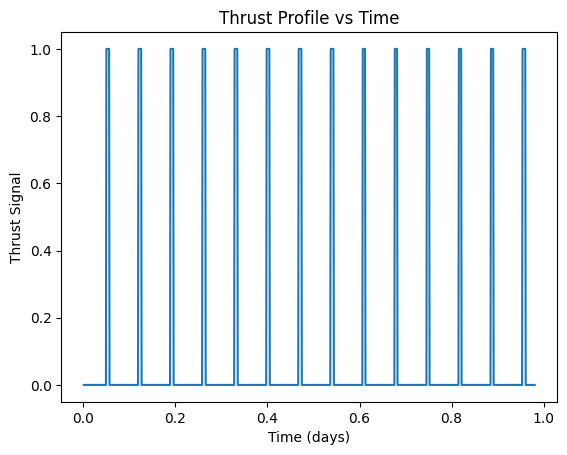

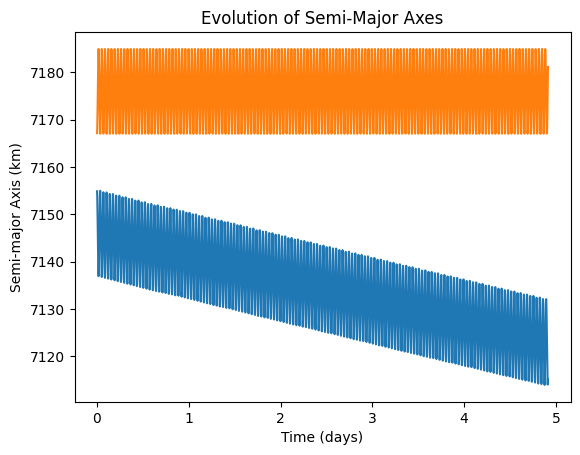

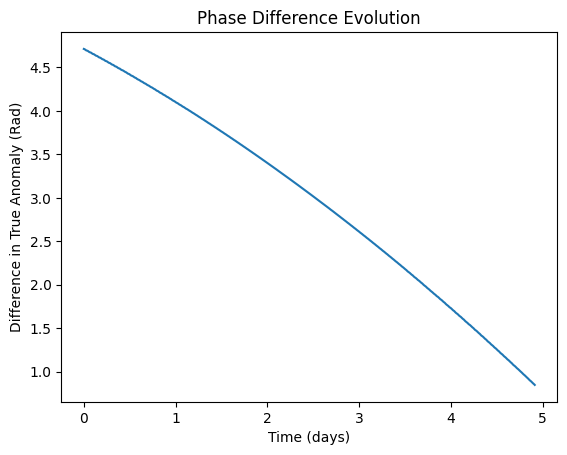

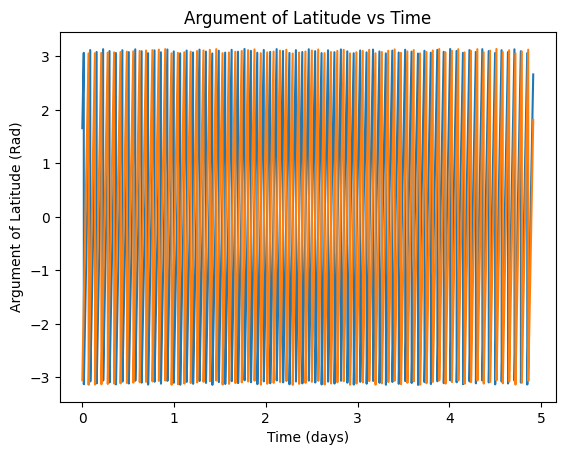

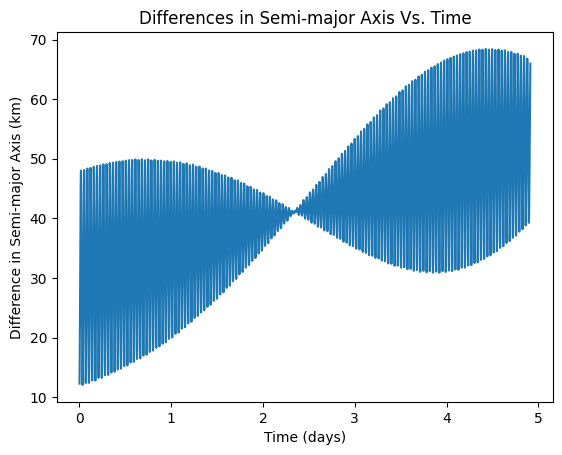

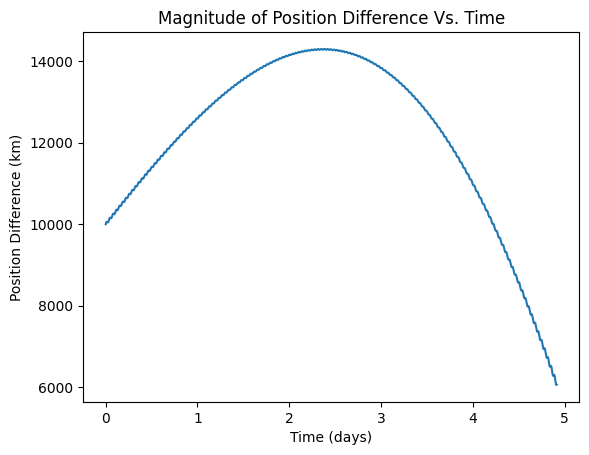

In [458]:
n = 1000
times = np.array(chaser_sat.times)*today
plt.plot(np.array(chaser_sat.times[:n])*today, chaser_sat.thrust_profile[:n])
plt.title('Thrust Profile vs Time')
plt.xlabel("Time (days)")
plt.ylabel("Thrust Signal")
plt.show()


plt.plot(times, chaser_sat.a_s)
plt.plot(times, target_sat.a_s)
plt.title('Evolution of Semi-Major Axes')
plt.xlabel("Time (days)")
plt.ylabel("Semi-major Axis (km)")
plt.show()

nu_diffs = [x - y for x, y in zip(target_sat.nus, chaser_sat.nus)]
nu_diffs = np.array(nu_diffs)
nu_diffs = np.where(nu_diffs < 0, nu_diffs + 2*np.pi, nu_diffs)
plt.title('Phase Difference Evolution')
plt.xlabel("Time (days)")
plt.ylabel("Difference in True Anomaly (Rad)")
plt.plot(times, nu_diffs)
plt.show()

plt.plot(times, target_sat.nus)
plt.plot(times, chaser_sat.nus)
plt.title('Argument of Latitude vs Time')
plt.xlabel("Time (days)")
plt.ylabel("Argument of Latitude (Rad)")
plt.show()

a_diffs = [x - y for x, y in zip(target_sat.a_s, chaser_sat.a_s)]
plt.plot(times, a_diffs)
plt.title('Differences in Semi-major Axis Vs. Time')
plt.xlabel("Time (days)")
plt.ylabel("Difference in Semi-major Axis (km)")
plt.show()

r_diffs = [LA.norm(x - y) for x, y in zip(target_sat.positions, chaser_sat.positions)]
plt.plot(times, r_diffs)
plt.title('Magnitude of Position Difference Vs. Time')
plt.xlabel("Time (days)")
plt.ylabel("Position Difference (km)")
plt.show()





plt.show()


In [459]:
print("Closest Approach Distance", min(r_diffs), " km")

Closest Approach Distance 6060.984580702114  km


## Validation of Analytical Equations

This short section reproduces the evolution of the orbital elements found in the case study from the referenced paper
validating that the equations of motion are accurately captured

In [383]:
#instantiate orbits with worst case true anomalies (farthest apart)
sat_mass = 500
sat_thrust = .00045
acc = sat_mass/sat_thrust
mu = 398600.4418

torad = np.pi/180
todeg = 1/torad

a_c = 10000
ecc_c = 0
inc_c = 51*torad
RAAN_c = 250*torad
true_anom_c = 0*torad


a_t = 24200
ecc_t = 0
inc_t = 56*torad
RAAN_t = 150*torad
true_anom_t = 180*torad

sat_acc = 1.5e-7

dnu = calculate_phase_analytical(acc,a_t, a_c, mu)
print(dnu)

7.437106699515776e-10


C:\Users\jbkra\AppData\Local\Temp\ipykernel_268\3841132083.py:7: RuntimeWarning: invalid value encountered in divide
  k2 = -4*np.log(a_t/a_i)/(i_t - inc_i)


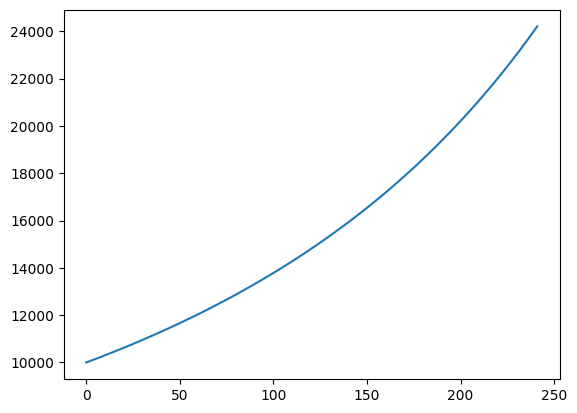

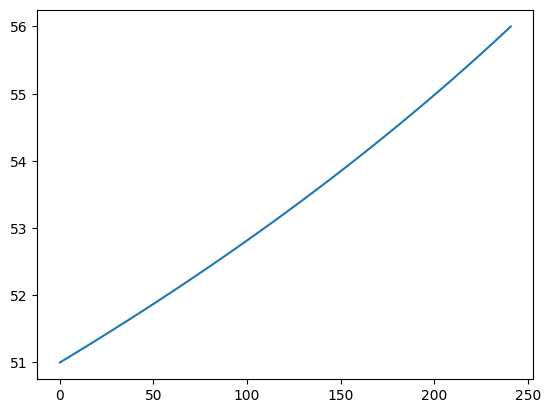

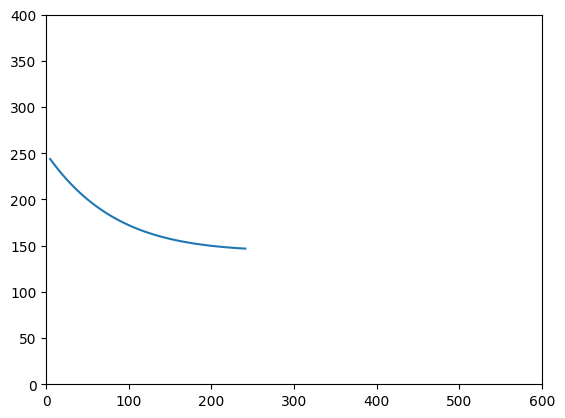

In [384]:

psi = 67.02*torad

B = analytical_beta(psi, inc_t, inc_c, a_t, a_c)

tof1 = TOF1(psi, inc_t, inc_c, a_t, a_c, sat_acc, mu)

ts = np.linspace(0,tof1)

# tof1 = tof1/(60*60*24)
RAAN_f =  Phase1_RAAN_Evolution(psi, inc_t, inc_c, a_t, a_c, sat_acc, mu, B, J2, R, RAAN_c)
    
RAAN_f = RAAN_f*todeg

a_t, i_t, RAAN_t = coe_evolution(psi, inc_t, inc_c, a_t, a_c, sat_acc, mu, B, J2, R, RAAN_c, ts)



ts = ts/(60*60*24)
plt.plot(ts, a_t)
plt.show()
plt.plot(ts, i_t*todeg)
plt.show()
plt.plot(ts, RAAN_t*todeg)
plt.ylim(0, 400)
plt.xlim(0,600)
plt.show()

In [372]:
import numpy as np

def wrap_true_anomaly(angle):
    wrapped_angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

# Example usage
true_anomaly = 3.5  # Replace with your true anomaly value
wrapped_true_anomaly = wrap_true_anomaly(true_anomaly)

print("Original True Anomaly:", true_anomaly)
print("Wrapped True Anomaly:", wrapped_true_anomaly)

Original True Anomaly: 3.5
Wrapped True Anomaly: -2.7831853071795862
